## Installing Python Packages

In [1]:
! pip install --upgrade --quiet transformers bitsandbytes datasets evaluate peft trl scikit-learn kaggle


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## Loading and Processing the Dataset

In [2]:
!kaggle datasets download -d orvile/brain-cancer-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/orvile/brain-cancer-mri-dataset
License(s): CC-BY-SA-4.0
 90%|████████████████████████████████████▉    | 130M/144M [00:00<00:00, 231MB/s]
100%|█████████████████████████████████████████| 144M/144M [00:01<00:00, 108MB/s]


In [3]:
from datasets import load_dataset

data_dir = "./Brain_Cancer raw MRI data/Brain_Cancer"

# Define proportions for train and validation splits
train_size = 0.8  
validation_size = 0.2  


data = load_dataset("imagefolder", data_dir=data_dir, split="train")

# Split the dataset into train and validation sets
data = data.train_test_split(
    train_size=train_size,
    test_size=validation_size,
    shuffle=True,
    seed=42,
)

# Rename the 'test' split to 'validation'
data["validation"] = data.pop("test")

# Display dataset details
print(data)


Resolving data files:   0%|          | 0/6056 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4844
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1212
    })
})


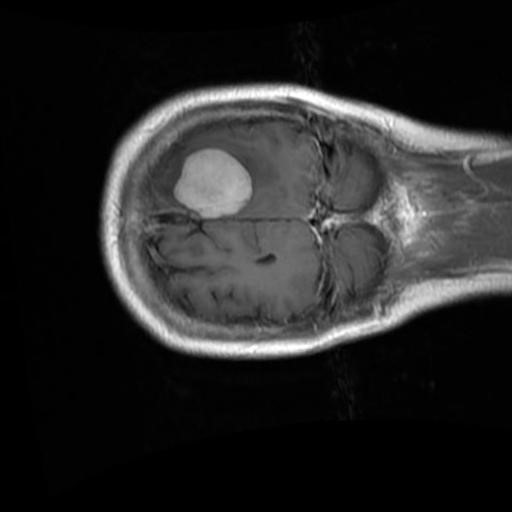

In [4]:
# Display the first image (as a PIL object)
data["train"][0]["image"]


In [5]:
# Display the corresponding label
print(data["train"][0]["label"])

1


In [6]:
BRAIN_CANCER_CLASSES = data["train"].features["label"].names
print("Detected classes:", BRAIN_CANCER_CLASSES)

Detected classes: ['brain_glioma', 'brain_menin', 'brain_tumor']


In [7]:
BRAIN_CANCER_CLASSES = ['A: brain glioma', 'B: brain menin', 'C: brain tumor']

options = "\n".join(BRAIN_CANCER_CLASSES)
PROMPT = f"What is the most likely type of brain cancer shown in the MRI image?\n{options}"


In [8]:
def format_data(example: dict[str, any]) -> dict[str, any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": BRAIN_CANCER_CLASSES[example["label"]],
                },
            ],
        },
    ]
    return example

# Apply the formatting to the dataset
formatted_data = data.map(format_data)

# Display a sample formatted data point
formatted_data["train"][0]["messages"]


Map:   0%|          | 0/4844 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

[{'content': [{'text': None, 'type': 'image'},
   {'text': 'What is the most likely type of brain cancer shown in the MRI image?\nA: brain glioma\nB: brain menin\nC: brain tumor',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'text': 'B: brain menin', 'type': 'text'}],
  'role': 'assistant'}]

## Loading the Model and Tokenizer

In [9]:
from huggingface_hub import login
import os

hf_token = os.environ.get("HF_TOKEN")
login(hf_token)


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [10]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-it"

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Setting up the Model

In [11]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [12]:
def collate_fn(examples: list[dict[str, any]]):
    texts = []
    images = []
    for example in examples:
        images.append([example["image"]])
        texts.append(
            processor.apply_chat_template(
                example["messages"], add_generation_prompt=False, tokenize=False
            ).strip()
        )

    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch


In [13]:
from trl import SFTConfig

args = SFTConfig(
    output_dir="medgemma-brain-cancer",            
    num_train_epochs=1,                       
    per_device_train_batch_size=8,                           
    per_device_eval_batch_size=8,                            
    gradient_accumulation_steps=8,                           
    gradient_checkpointing=True,                             
    optim="adamw_torch_fused",                               
    logging_steps=0.1,                                        
    save_strategy="epoch",                                   
    eval_strategy="steps",                                   
    eval_steps=0.1,                                           
    learning_rate=2e-4,                             
    bf16=True,                                               
    max_grad_norm=0.3,                                       
    warmup_ratio=0.03,                                       
    lr_scheduler_type="linear",                              
    push_to_hub=True,                                        
    report_to="none",
    gradient_checkpointing_kwargs={"use_reentrant": False},  
    dataset_kwargs={"skip_prepare_dataset": True},           
    remove_unused_columns = False,                           
    label_names=["labels"],                                  
)

In [14]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=formatted_data["train"],
    eval_dataset=formatted_data["validation"].shuffle().select(range(50)), 
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

## Model Training

In [15]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
8,31.499300,1.393780
16,5.916200,0.373517
24,1.435700,0.088616
32,0.532700,0.060583
40,0.417600,0.046456
48,0.355700,0.039753
56,0.316100,0.043567
64,0.322100,0.037666
72,0.287500,0.035154


TrainOutput(global_step=76, training_loss=4.338119332727633, metrics={'train_runtime': 4112.8912, 'train_samples_per_second': 1.178, 'train_steps_per_second': 0.018, 'total_flos': 3.853875156358656e+16, 'train_loss': 4.338119332727633})

In [16]:
trainer.save_model()

Uploading...:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

## Model Evaluation

In [30]:
del model
del trainer
torch.cuda.empty_cache()

### Setting up for model testing

In [31]:
def format_test_data(example: dict[str, any]) -> dict[str, any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
    ]
    return example

In [32]:
test_data = data["validation"]
test_data = test_data.map(format_test_data)

In [33]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Ground-truth labels
REFERENCES = test_data["label"]


def compute_metrics(predictions: list[int]) -> dict[str, float]:
    metrics = {}
    metrics.update(
        accuracy_metric.compute(
            predictions=predictions,
            references=REFERENCES,
        )
    )
    metrics.update(
        f1_metric.compute(
            predictions=predictions,
            references=REFERENCES,
            average="weighted",
        )
    )
    return metrics


In [34]:
from datasets import ClassLabel

test_data = test_data.cast_column(
    "label",
    ClassLabel(names=BRAIN_CANCER_CLASSES)
)

In [35]:
LABEL_FEATURE = test_data.features["label"]

ALT_LABELS = dict([
    (label, f"({label.replace(': ', ') ')}") for label in BRAIN_CANCER_CLASSES
])

In [36]:
def postprocess(prediction, do_full_match: bool = False) -> int:
    if isinstance(prediction, str):
        response_text = prediction
    else:
        response_text = prediction[0]["generated_text"]

    if do_full_match:
        return LABEL_FEATURE.str2int(response_text)

    for label in BRAIN_CANCER_CLASSES:
        # accept canonical or alternative wording
        if label in response_text or ALT_LABELS[label] in response_text:
            return LABEL_FEATURE.str2int(label)

    return -1


### Model performance on the base model

In [37]:
import torch
from transformers import AutoModelForImageTextToText, AutoProcessor

model_kwargs = dict(
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model = AutoModelForImageTextToText.from_pretrained(
    model_id, **model_kwargs
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
from transformers import GenerationConfig
gen_cfg = GenerationConfig.from_pretrained(model_id)
gen_cfg.update(
    do_sample          = False, 
    top_k              = None, 
    top_p              = None,
    cache_implementation = "dynamic" 
)
model.generation_config = gen_cfg

In [39]:
processor  = AutoProcessor.from_pretrained(args.output_dir)
tok = processor.tokenizer

model.config.pad_token_id            = tok.pad_token_id
model.generation_config.pad_token_id = tok.pad_token_id

In [40]:
def chat_to_prompt(chat_turns):
    return processor.apply_chat_template(
        chat_turns,
        add_generation_prompt=True,   # tells the model "your turn"
        tokenize=False                # we want raw text, not ids
    )

prompts = [chat_to_prompt(c) for c in test_data["messages"]]
images  = test_data["image"]                         # already a list of PIL images
assert len(prompts) == len(images), "1 prompt must match 1 image!"

In [41]:
import torch
from typing import List, Any, Callable


def batch_predict(
    prompts,
    images,
    model,
    processor,
    postprocess,
    *,
    batch_size=64,
    device="cuda",
    dtype=torch.bfloat16,
    **gen_kwargs
):
    preds = []
    for i in range(0, len(prompts), batch_size):
        texts = prompts[i : i + batch_size]
        imgs = [[img] for img in images[i : i + batch_size]]
        enc = processor(text=texts, images=imgs, padding=True, return_tensors="pt").to(
            device, dtype=dtype
        )
        lens = enc["attention_mask"].sum(dim=1)
        with torch.inference_mode():
            out = model.generate(
                **enc,
                disable_compile=True,
                **gen_kwargs
            )
        for seq, ln in zip(out, lens):
            ans = processor.decode(seq[ln:], skip_special_tokens=True)
            preds.append(postprocess(ans))
    return preds


In [42]:
bf_preds = batch_predict(
    model         = model,
    processor     = processor,
    prompts       = prompts,
    images        = images,
    batch_size    = 64,
    max_new_tokens= 40,          # forwarded to generate
    postprocess= postprocess, # your label-mapping function
)

print("Completed", len(bf_preds), "samples")

Completed 1212 samples


In [43]:
bf_metrics = compute_metrics(bf_preds)
print(f"Baseline metrics: {bf_metrics}")

Baseline metrics: {'accuracy': 0.33745874587458746, 'f1': 0.1737287617650654}


In [44]:
import torch
from typing import Union, Dict, Any, List
from transformers import AutoModelForImageTextToText, AutoProcessor


def predict_one(
    prompt,
    image,
    model,
    processor,
    *,
    device="cuda",
    dtype=torch.bfloat16,
    disable_compile=True,
    **gen_kwargs
) -> str:
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(
        device, dtype=dtype
    )
    plen = inputs["input_ids"].shape[-1]
    with torch.inference_mode():
        ids = model.generate(
            **inputs,
            disable_compile=disable_compile,
            **gen_kwargs
        )
    return processor.decode(ids[0, plen:], skip_special_tokens=True)


In [45]:
idx     = 10
chat    = test_data["messages"][idx]
prompt  = processor.apply_chat_template(
            chat,
            add_generation_prompt=True,
            tokenize=False
          )

# run the one-sample helper
answer = predict_one(
    prompt   = prompt,
    image    = test_data["image"][idx],
    model    = model,
    processor= processor,
    max_new_tokens = 40 
)

print("Model answer:", answer)

Model answer: Based on the MRI image, the most likely type of brain cancer is **A: brain glioma**.

Here's why:

*   **Gliomas** are a common type of brain tumor


### Model performance on the fine-tuned model

In [47]:
model = AutoModelForImageTextToText.from_pretrained(
    args.output_dir, **model_kwargs
)
model.generation_config = gen_cfg


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [48]:
processor  = AutoProcessor.from_pretrained(args.output_dir)
tok = processor.tokenizer

model.config.pad_token_id            = tok.pad_token_id
model.generation_config.pad_token_id = tok.pad_token_id

In [49]:
af_preds = batch_predict(
    model         = model,
    processor     = processor,
    prompts       = prompts,
    images        = images,
    batch_size    = 64,
    max_new_tokens= 40,          # forwarded to generate
    postprocess= postprocess, # your label-mapping function
)

print("Completed", len(af_preds), "samples")

Completed 1212 samples


In [50]:
af_metrics = compute_metrics(af_preds)
print(f"Fine-tuned metrics: {af_metrics}")

Fine-tuned metrics: {'accuracy': 0.8927392739273927, 'f1': 0.892641793935792}


In [51]:
idx     = 10
chat    = test_data["messages"][idx]
prompt  = processor.apply_chat_template(
            chat,
            add_generation_prompt=True,
            tokenize=False
          )

# run the one-sample helper
answer = predict_one(
    prompt   = prompt,
    image    = test_data["image"][idx],
    model    = model,
    processor= processor,
    max_new_tokens = 40              # any generate-kwargs you need
)

print("Model answer:", answer)

Model answer: C: brain tumor


In [52]:
data["validation"][10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 2}